## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Frequency Domain Response Function

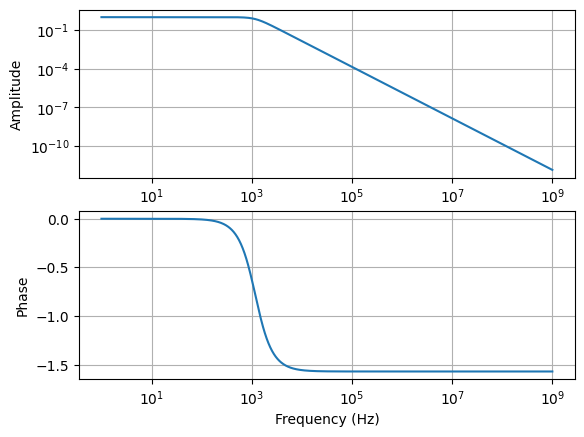

In [41]:
def reactance_factor(f, temperature_Kelvin):
    temperature_Celcius = temperature_Kelvin - 273.15
    R0 = 8 * 2 + 10# Ohm
    C = 7e-10 * (1 + temperature_Celcius * 0.00338)# F
    gamma = 3.3e13
    omega = 2 * np.pi * f
    im = 1j
    wXp = gamma / (1 + im * omega * C * gamma)
    wX = omega * R0 + wXp
    return np.where(f < 0, np.conj(wXp / wX), wXp / wX)

# plot the reactance_factor in frequency domain (log scale) from 1Hz to 1GHz
# with two subplot : amplitude and phase
f = np.logspace(0, 9, 1000, base=10)
X = reactance_factor(f, 273.15)
plt.figure()
plt.subplot(211)
plt.plot(f, np.abs(X))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.subplot(212)
plt.plot(f, np.angle(X))
plt.xscale('log')
plt.ylabel('Phase')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.show()

# Time Domain Reponse Function

7.533946488359613


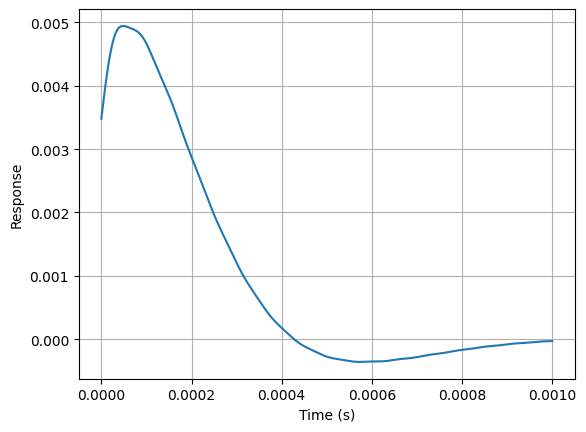

In [42]:
# make time_response_function
def time_response(end, dt, temperature=273.15):
    w_end = 1e5
    dw = 10
    w = np.arange(0, w_end, dw)
    integrant = lambda w, t: (reactance_factor(w / 2 / np.pi, temperature) * np.exp(1j * w * t)).real
    integrant_values = np.array([integrant(w, t) for t in np.arange(0, end, dt)])
    integral = np.trapz(integrant_values, w, axis=1) * dt * dw / np.pi
    print(sum(integral))
    return integral / sum(integral)
    
# plot the time_response_function
time_end = 1e-3
dt = 1e-6
time_array = np.arange(0, 1e-3, 1e-6)
time_response_array = time_response(time_end, dt)
plt.figure()
plt.plot(time_array, time_response_array)
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.grid()
plt.show()

# Response at Heaviside Function

7.518971229513657


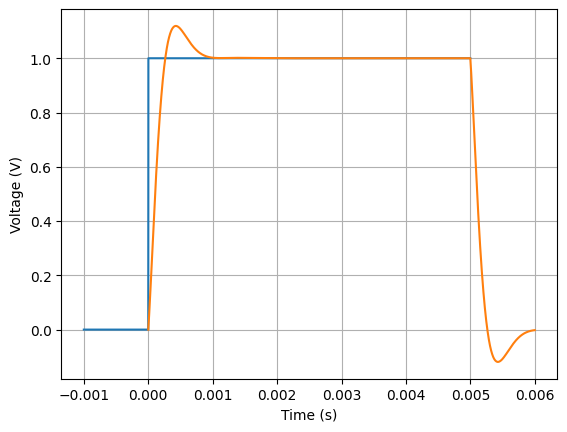

In [43]:
# plot the response voltage in time domain
def voltage(t, t_0):
    if t < t_0:
        return 0
    else:
        return 1

def response(voltage_array, time_end, dt, temperature=273.15):
    t_response_f = time_response(time_end, dt, temperature)
    return np.convolve(voltage_array, t_response_f, mode='same')

suscept_time_end = 2e-3
suscept_dt = 1e-6
time = np.arange(-1e-3, 5e-3, suscept_dt)
voltage_array = np.array([voltage(t, 0) for t in time])
response_array = response(voltage_array, suscept_time_end, suscept_dt)
plt.figure()
plt.plot(time, voltage_array)
plt.plot(time + suscept_time_end/2, response_array)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()


# Giant Step Simulation

X_stepsize (angs):  347.88086780921066
Z_stepsize (angs):  734.4151653750002
HpM_X:  774.7194528626665
HpM_Z:  1156.4864660100154
7.5094190698808125
7.5094190698808125


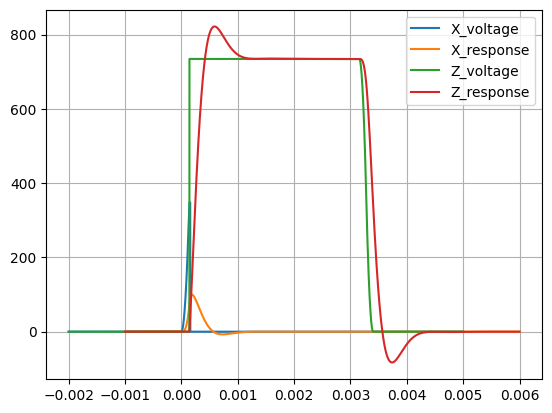

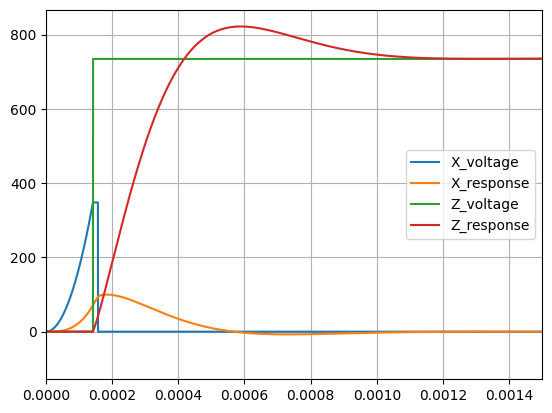

In [45]:
# giant step simulation
CYCLE = 11.625744e-9
OUTPUTCYCLE = 3.6e-6

def X_voltage(t, HpM_X):
    T_parab = np.sqrt(2) * np.sqrt(HpM_X) * OUTPUTCYCLE
    relax_delay = 5 * 259 * CYCLE
    if t < 0:
        return 0
    elif t < T_parab:
        return (t / T_parab) ** 2
    elif t < T_parab + relax_delay:
        return 1
    else:
        return 0

def Z_voltage(t, HpM_X, HpM_Z, tip_delay):
    T_parab_X = np.sqrt(2) * np.sqrt(HpM_X) * OUTPUTCYCLE
    T_parab_Z = np.sqrt(HpM_Z) * OUTPUTCYCLE
    relax_delay = 5 * 259 * CYCLE + tip_delay
    if t < T_parab_X:
        return 0
    elif t < T_parab_X + relax_delay:
        return 1
    elif t < T_parab_X + relax_delay + T_parab_Z:
        return 1 - 0.5 * ((t - T_parab_X - relax_delay) / T_parab_Z)**2
    elif t < T_parab_X + relax_delay + T_parab_Z * 2:
        return 0.5 * ((t - T_parab_X - relax_delay - T_parab_Z * 2) / T_parab_Z)**2
    else:
        return 0


class Piezo():
    def __init__(self, temperature):
        self.temperature = temperature
        self.length = 1.27e8 # 12.7 mm in angs
        self.thickness = 7.62e6 # 0.762 mm in angs
        self.mean_diameter = 2.413e7 # 2.413 mm in angs

    def d31(self):
        temp = self.temperature
        temp2 = temp * temp
        temp3 = temp2 * temp
        temp4 = temp3 * temp
        temp5 = temp4 * temp
        a0 = 38.6587	- 10.05373351
        a1 = 0.483506 + 0.084041014
        a2 = 0.000706133
        a3 = -0.0000154086
        a4 = 0.0000000693543
        a5 = -0.0000000000954317
        return (a0 + a1 * temp + a2 * temp2 + a3 * temp3 + a4 * temp4 + a5 * temp5) / 100.0

    
    def angs(self, voltage):
        return 0.9 * self.d31() * voltage * self.length * self.length / self.mean_diameter / self.thickness
    
    def z_angs(self, voltage):
        return self.d31() * voltage * self.length / self.thickness

tip_delay = 3e-3
a_percent = 1 # percent of gravity acceleration
X_stepsize = 2.5 # V
Z_stepsize = 2.5 # V

temperature = 300 # K
piezo = Piezo(temperature)
X_angs = piezo.angs(X_stepsize)
Z_angs = piezo.z_angs(Z_stepsize) * 10
acceleration = a_percent * 9.8 * 1e10 # angstrom / s^2
HpM_X = 2 * np.sqrt(2) * X_angs / acceleration / OUTPUTCYCLE / OUTPUTCYCLE
HpM_Z = 2 * Z_angs / acceleration / OUTPUTCYCLE / OUTPUTCYCLE
print("X_stepsize (angs): ", X_angs)
print("Z_stepsize (angs): ", Z_angs)
print("HpM_X: ", HpM_X)
print("HpM_Z: ", HpM_Z)

suscept_time_end = 2e-3
suscept_dt = 1e-7
time = np.arange(-2e-3, 5e-3, suscept_dt)
X_voltage_array = np.array([X_angs * X_voltage(t, HpM_X) for t in time])
Z_voltage_array = np.array([Z_angs * Z_voltage(t, HpM_X, HpM_Z, tip_delay) for t in time])
X_response_array = response(X_voltage_array, suscept_time_end, suscept_dt, temperature)
Z_response_array = response(Z_voltage_array, suscept_time_end, suscept_dt, temperature)
plt.figure()
plt.plot(time, X_voltage_array, label='X_voltage')
plt.plot(time + suscept_time_end/2, X_response_array, label='X_response')
plt.plot(time, Z_voltage_array, label='Z_voltage')
plt.plot(time + suscept_time_end/2, Z_response_array, label='Z_response')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time, X_voltage_array, label='X_voltage')
plt.plot(time + suscept_time_end/2, X_response_array, label='X_response')
plt.plot(time, Z_voltage_array, label='Z_voltage')
plt.plot(time + suscept_time_end/2, Z_response_array, label='Z_response')
plt.xlim(0, 0.0015)
plt.legend()
plt.grid()
plt.show()

# Show Trajectory

max z_accel (angs/s^2):  12279528143991.12
min z_accel (angs/s^2):  -26842848140.51818
3
3
3


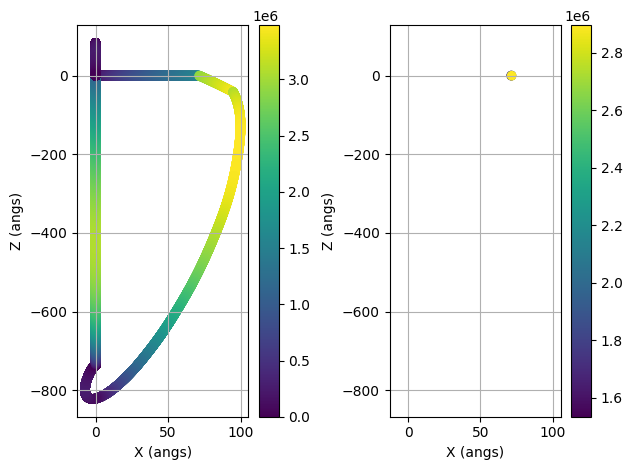

In [46]:
## plot the response in xz plane (color mapping with speed)
def speed(X_response_array, Z_response_array, dt):
    return np.sqrt(np.gradient(X_response_array, dt, edge_order=2)**2 + np.gradient(Z_response_array, dt, edge_order=2)**2)

def z_acceleration(Z_response_array, dt):
    return np.gradient(np.gradient(Z_response_array, dt, edge_order=2), dt, edge_order=2)

speed_array = speed(X_response_array, Z_response_array, suscept_dt)
z_accel_array = z_acceleration(Z_response_array, suscept_dt)
print("max z_accel (angs/s^2): ", max(z_accel_array))
print("min z_accel (angs/s^2): ", min(z_accel_array))

filtered_X_response_array = X_response_array[np.abs(z_accel_array) > 9.8e10]
filtered_Z_response_array = Z_response_array[np.abs(z_accel_array) > 9.8e10]
filtered_speed_array = speed_array[np.abs(z_accel_array) > 9.8e10]

print(len(filtered_X_response_array))
print(len(filtered_Z_response_array))
print(len(filtered_speed_array))

plt.figure()
plt.subplot(121)
plt.scatter(X_response_array, -Z_response_array, c=speed_array, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('X (angs)')
plt.ylabel('Z (angs)')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

plt.subplot(122)
plt.scatter(filtered_X_response_array, -filtered_Z_response_array, c=filtered_speed_array, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('X (angs)')
plt.ylabel('Z (angs)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.show()

# Guess Sample Trajectory (w/o Slope of Sample Holder)

X Jump Distance =  0.000108502167165625  at  11417
Z Jump Distance =  -4.737306926068185e-06  at  11417
X Jump Distance =  3.184064526351449e-05  at  11418
Z Jump Distance =  -1.390192595020491e-06  at  11418
X Jump Distance =  76.96012504049014  at  12089
Z Jump Distance =  -3.3601516256247894  at  12089


Text(0, 0.5, 'Z (angs)')

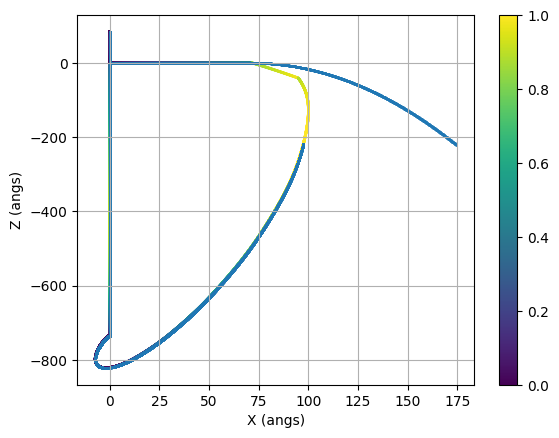

In [ ]:
def guess_sample_trajectory(X_response_array, Z_response_array, dt, tilting_radian = 0):
    # note that Z is inverted
    x_speed_array = np.gradient(X_response_array, dt, edge_order=2)
    z_accel_array = z_acceleration(Z_response_array, dt)
    new_X_sample = np.zeros(len(X_response_array))
    new_Z_sample = np.zeros(len(Z_response_array))
    gravity = 9.8e10
    flying = False
    flying_x_speed = 0
    flying_z_speed = 0
    total_jump_distance = 0
    for i in range(0, len(X_response_array)):
        if not flying:
            if z_accel_array[i] > gravity:
                flying_x_speed = x_speed_array[i]
                flying_z_speed = 0.5 * gravity * dt
                flying = True
            else:
                new_X_sample[i] = X_response_array[i]
                new_Z_sample[i] = Z_response_array[i]
        if flying:
            guessed_dx = flying_x_speed * dt
            flying_z_speed += gravity * dt
            guessed_dz = flying_z_speed * dt
            guessed_flying_x = new_X_sample[i-1] + guessed_dx
            guessed_flying_z = new_Z_sample[i-1] + guessed_dz
            if Z_response_array[i] < guessed_flying_z + np.tan(tilting_radian) * (guessed_flying_x - X_response_array[i]):
                print("X Jump Distance = ", (guessed_flying_x - X_response_array[i]), " at ", i)
                print("Z Jump Distance = ", np.tan(tilting_radian) * (guessed_flying_x - X_response_array[i]), " at ", i)
                total_jump_distance += guessed_flying_x - X_response_array[i]
                flying = False
                new_X_sample[i] = X_response_array[i]
                new_Z_sample[i] = Z_response_array[i]
            else:
                new_X_sample[i] = guessed_flying_x
                new_Z_sample[i] = guessed_flying_z
    return new_X_sample, new_Z_sample, total_jump_distance

tilting_radian = -2.5 * np.pi / 180
X_sample, Z_sample, _ = guess_sample_trajectory(X_response_array, Z_response_array, suscept_dt, tilting_radian)

plt.figure()
plt.scatter(X_response_array, -Z_response_array, c=speed_array, cmap='viridis', s=1)
plt.scatter(X_sample, -Z_sample, s=1)
plt.colorbar()
plt.grid()
plt.xlabel('X (angs)')
plt.ylabel('Z (angs)')

# Make flying distance Parameter Map

In [ ]:
def get_flying_distance(a_percent, stepsize, temperature=273.15):
    tip_delay = 3e-3
    X_stepsize = stepsize
    Z_stepsize = stepsize

    piezo = Piezo(temperature)
    X_angs = piezo.angs(X_stepsize)
    Z_angs = piezo.z_angs(Z_stepsize) * 10
    acceleration = a_percent * 9.8 * 1e10 # angstrom / s^2
    HpM_X = 2 * np.sqrt(2) * X_angs / acceleration / OUTPUTCYCLE / OUTPUTCYCLE
    HpM_Z = 2 * Z_angs / acceleration / OUTPUTCYCLE / OUTPUTCYCLE

    suscept_time_end = 1.5e-3
    suscept_dt = 1e-7
    time = np.arange(-1.5e-3, 2e-3, suscept_dt)
    X_voltage_array = np.array([X_angs * X_voltage(t, HpM_X) for t in time])
    Z_voltage_array = np.array([Z_angs * Z_voltage(t, HpM_X, HpM_Z, tip_delay) for t in time])
    X_response_array = response(X_voltage_array, suscept_time_end, suscept_dt, temperature)
    Z_response_array = response(Z_voltage_array, suscept_time_end, suscept_dt, temperature)

    tilting_radian = -2.5 * np.pi / 180
    _, _, jump_distance = guess_sample_trajectory(X_response_array, Z_response_array, suscept_dt, tilting_radian)
    return jump_distance

a_percent_list = np.linspace(0.1, 10, 100)
stepsize_list = np.linspace(0.1, 10, 100)

for a_percent in a_percent_list:
    for stepsize in stepsize_list:
        # use result.txt for saving the result
        # if current paremeter is already calculated, skip
        with open('result.txt', 'r') as f:
            if f.read().find(str(a_percent) + ' ' + str(stepsize)) != -1:
                continue
        jump_distance = get_flying_distance(a_percent, stepsize)
        with open('result.txt', 'a') as f:
            f.write(str(a_percent) + ' ' + str(stepsize) + ' ' + str(jump_distance) + '\n')
        print(a_percent, stepsize, jump_distance)